In [1]:
from cil.framework import  AcquisitionGeometry

from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D, show_geometry
from cil.utilities import noise

import scipy.special as sp

import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

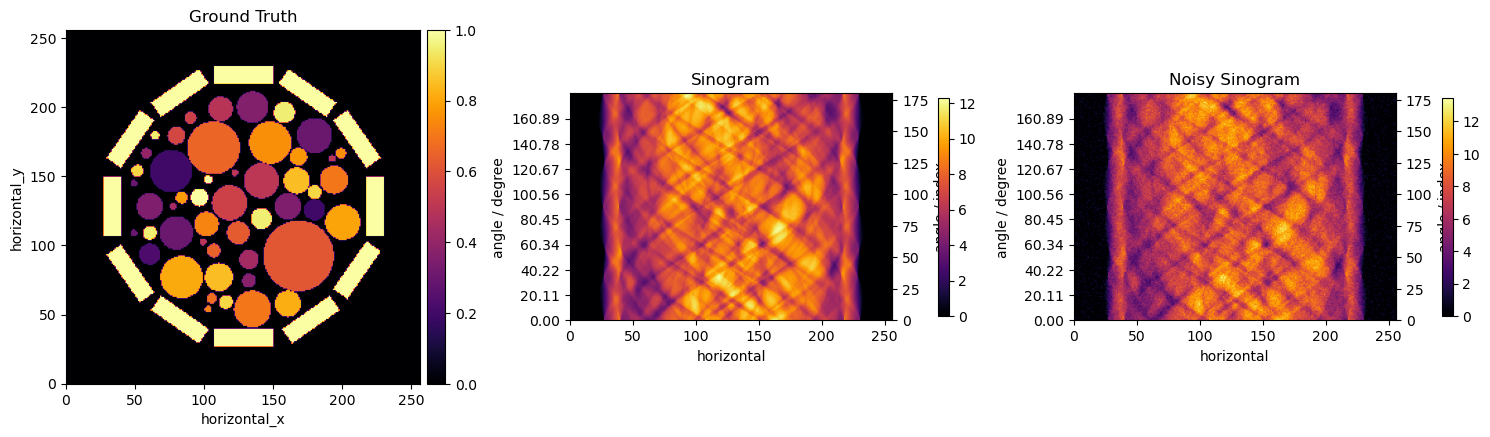

Saved image as e:\天天\undergraduate\3rd year\Project\code\example_sino.png


<Figure size 640x480 with 0 Axes>

In [3]:
# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'cpu')

# Create an acquisition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0

# Show numerical and noisy sinograms
f = show2D([phantom, sino, noisy_sino], title = ['Ground Truth','Sinogram','Noisy Sinogram'], num_cols=3, cmap = 'inferno')
f.save('example_sino.png')

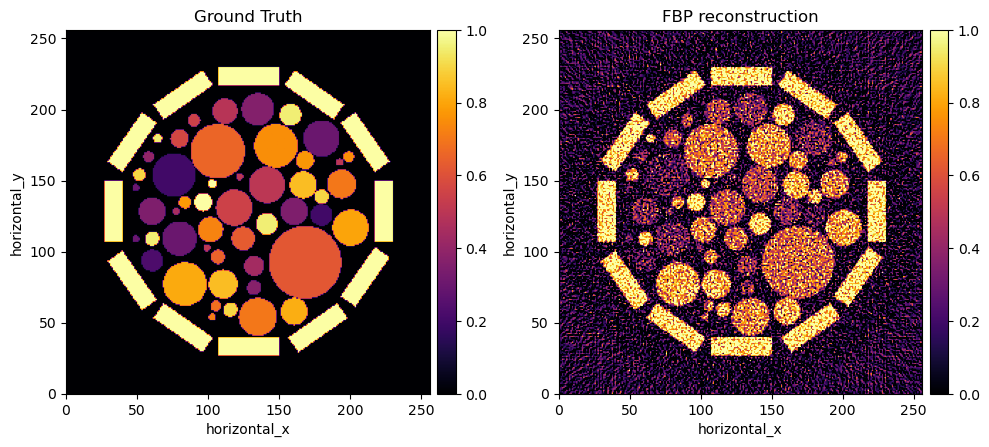

Saved image as e:\天天\undergraduate\3rd year\Project\code\fbp.png


<Figure size 640x480 with 0 Axes>

In [4]:
# Setup and run the FBP algorithm
fbp_recon = FBP(ig, ag,  device = 'cpu')(noisy_sino)

# Show reconstructions
fbp = show2D([phantom, fbp_recon], 
       title = ['Ground Truth','FBP reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))
fbp.save('fbp.png')

In [5]:
# Define BlockOperator K
Grad = GradientOperator(ig)
K = BlockOperator(A, Grad)

# Define BlockFunction f
alpha = 0.1
f1 = 0.5 * L2NormSquared(b=noisy_sino)
f2 = alpha * MixedL21Norm()
f = BlockFunction(f1, f2)

# Define Function g
g = IndicatorBox(lower=0)

# Primal/Dual stepsizes
normK = K.norm()
sigma = 1./normK
tau = 1./normK

# Setup and run PDHG
pdhg = PDHG(f = f, g = g, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 200,
            update_objective_interval = 50)
pdhg.run(verbose=2)

     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    1.03515e+06  -0.00000e+00    1.03515e+06
       50        200         0.188    8.46026e+03   6.79323e+03    1.66703e+03
      100        200         0.165    7.66593e+03   7.69904e+03   -3.31148e+01
      150        200         0.160    7.57603e+03   7.50029e+03    7.57411e+01
      200        200         0.157    7.55696e+03   7.54231e+03    1.46554e+01
----------------------------------------------------------------------------
      200        200         0.157    7.55696e+03   7.54231e+03    1.46554e+01
Stop criterion has been reached.



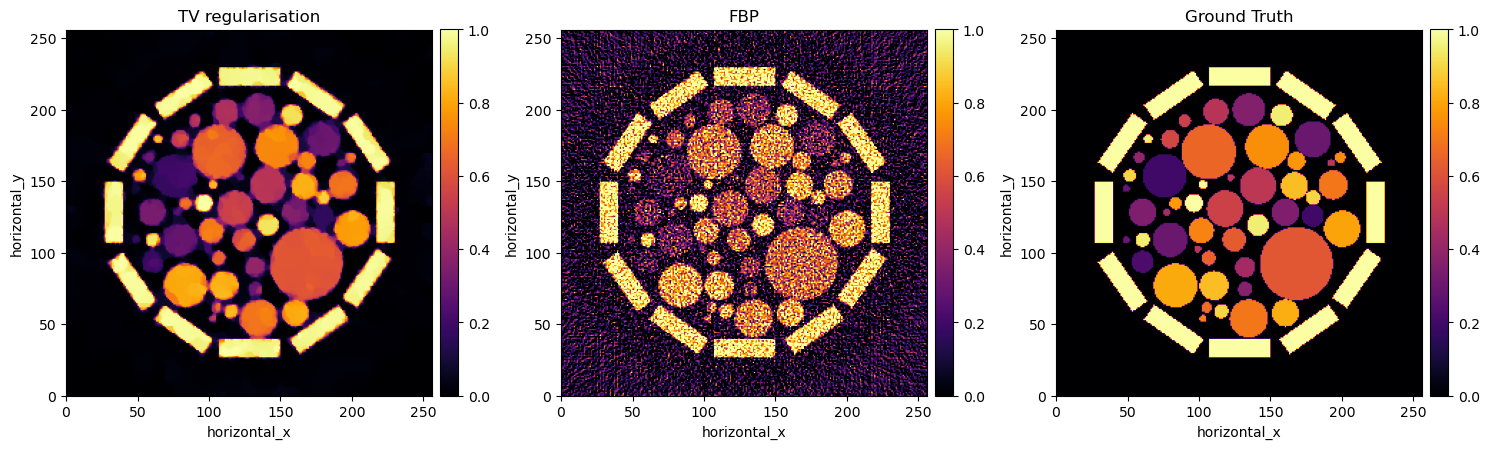

Saved image as e:\天天\undergraduate\3rd year\Project\code\tv.png


<Figure size 640x480 with 0 Axes>

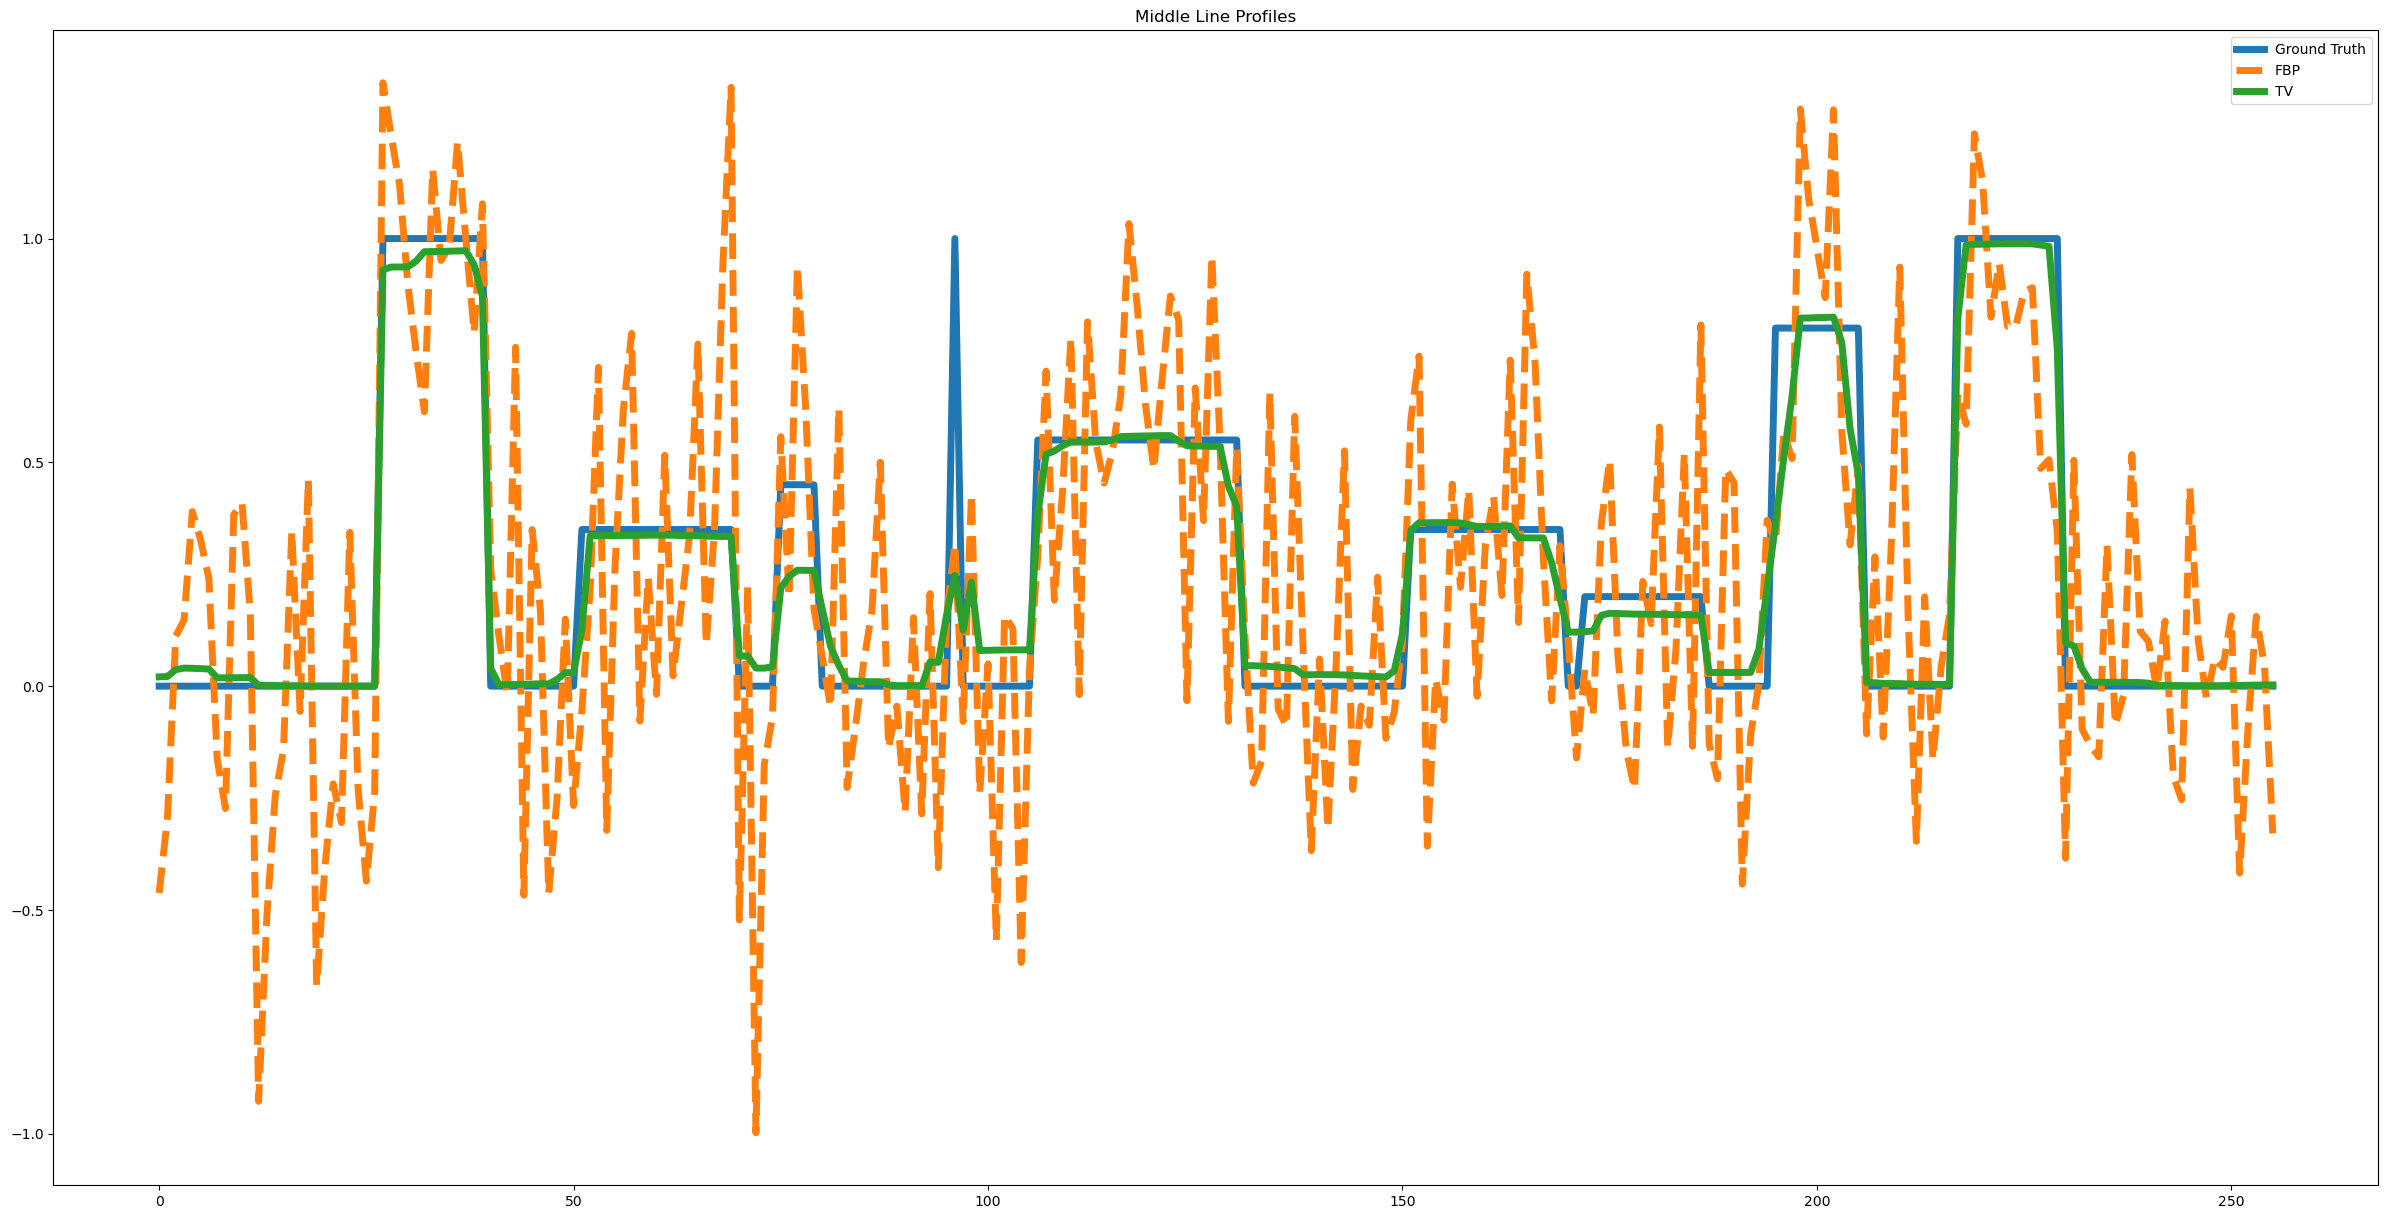

In [6]:
tv = show2D([pdhg.solution,fbp_recon, phantom], title = ['TV regularisation','FBP','Ground Truth'], cmap = 'inferno', num_cols=3, fix_range=(0,1.))
tv.save('tv.png')

# Plot middle line profile
plt.figure(figsize=(30,15))
plt.plot(phantom.get_slice(horizontal_y = int(N/2)).as_array(), label = 'Ground Truth', linewidth=5)
plt.plot(fbp_recon.get_slice(horizontal_y = int(N/2)).as_array(), label = 'FBP', linewidth=5, linestyle='dashed')
plt.plot(pdhg.solution.get_slice(horizontal_y = int(N/2)).as_array(), label = 'TV', linewidth=5)
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

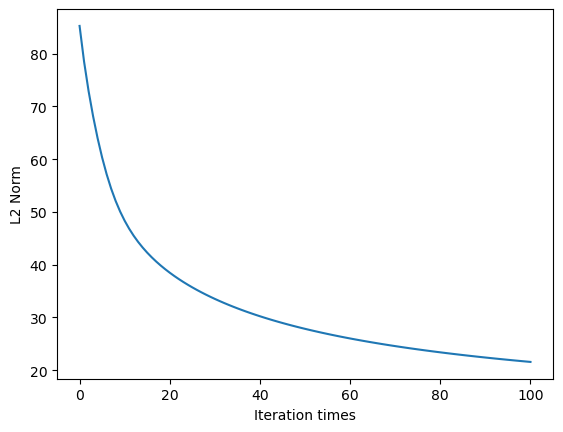

In [7]:
L2Norm = []


x00 = ig.allocate(value = 1)
ones1 = ag.allocate(value = 1)
m1 = A.adjoint(ones1)


for i in range(101):
    d1 = A.direct(x00)
    n1 = sino/d1
    p1 = A.adjoint(n1)
    x11 = p1*x00
    xnew1 = x11/m1
    x00 = xnew1
    
        
    L2squared = L2NormSquared(b = phantom)
    L2 = L2squared(xnew1)**(1/2)
    L2Norm.append(L2)


plt.plot(range(101), L2Norm)
plt.xlabel("Iteration times")
plt.ylabel("L2 Norm")
plt.savefig('l2.png')
plt.show()

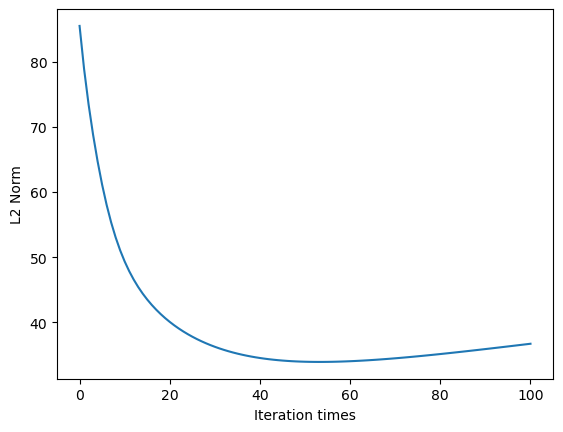

In [8]:
L2Norm = []


x00 = ig.allocate(value = 1)
ones1 = ag.allocate(value = 1)
m1 = A.adjoint(ones1)


for i in range(101):
    d1 = A.direct(x00)
    n1noise = noisy_sino/d1
    p1noise = A.adjoint(n1noise)
    x11noise = p1noise*x00
    xnew1noise = x11noise/m1
    x00 = xnew1noise
    
        
    L2squared = L2NormSquared(b = phantom)
    L2 = L2squared(xnew1noise)**(1/2)
    L2Norm.append(L2)


plt.plot(range(101), L2Norm)
plt.xlabel("Iteration times")
plt.ylabel("L2 Norm")
plt.savefig('l2noise.png')
plt.show()

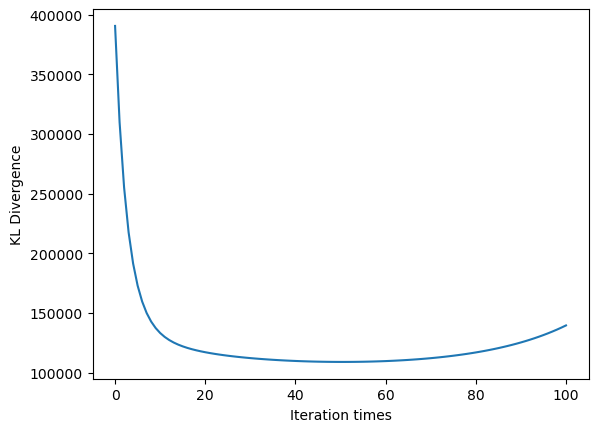

In [9]:
KL = []


x000 = ig.allocate(value = 1)
ones11 = ag.allocate(value = 1)
m11 = A.adjoint(ones11)


for i in range(101):
    d11 = A.direct(x00)
    n11 = sino/d11
    p11 = A.adjoint(n11)
    x11 = p11*x000
    xnew11 = x11/m11
    x000 = xnew11

    b = sino.as_array()
    a = (A.direct(xnew11)).as_array()
    

    div = sp.kl_div(b, a)
    div_sum = np.sum(div)
    KL.append(div_sum)


plt.plot(range(101), KL)
plt.xlabel("Iteration times")
plt.ylabel("KL Divergence")
plt.savefig('kl.png')
plt.show()

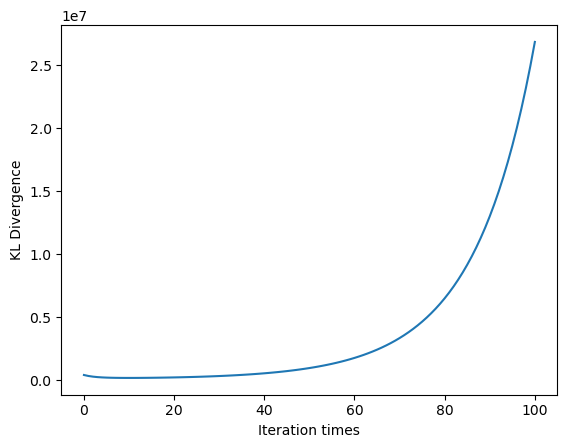

In [10]:
poisson_mean = np.maximum(0, sino.array)
poisson_noise = np.random.poisson(poisson_mean)

noisy_sino1 = ag.allocate()
noisy_sino1.fill(poisson_noise)

KL = []


x000 = ig.allocate(value = 1)
ones11 = ag.allocate(value = 1)
m11 = A.adjoint(ones11)


for i in range(101):
    d11 = A.direct(x00)
    n11noise = noisy_sino1/d11
    p11noise = A.adjoint(n11noise)
    x11noise = p11noise*x000
    xnew11noise = x11noise/m11
    x000 = xnew11noise

    bnoise = noisy_sino1.as_array()
    anoise = (A.direct(xnew11noise)).as_array()
    

    div = sp.kl_div(bnoise, anoise)
    div_sum = np.sum(div)
    KL.append(div_sum)


plt.plot(range(101), KL)
plt.xlabel("Iteration times")
plt.ylabel("KL Divergence")
plt.savefig('klnoise.png')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

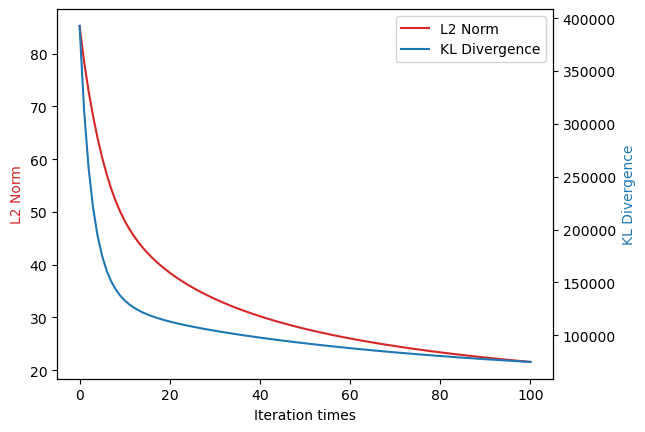

In [11]:
L2Norm = []


x00 = ig.allocate(value = 1)
ones1 = ag.allocate(value = 1)
m1 = A.adjoint(ones1)


for i in range(101):
    d1 = A.direct(x00)
    n1 = sino/d1
    p1 = A.adjoint(n1)
    x11 = p1*x00
    xnew1 = x11/m1
    x00 = xnew1
    
        
    L2squared = L2NormSquared(b = phantom)
    L2 = L2squared(xnew1)**(1/2)
    L2Norm.append(L2)
    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("Iteration times")
ax1.set_ylabel("L2 Norm", color = color)
lns1 = ax1.plot(range(101), L2Norm, color = color, label = "L2 Norm")


KL = []


x000 = ig.allocate(value = 1)
ones11 = ag.allocate(value = 1)
m11 = A.adjoint(ones11)


for i in range(101):
    d11 = A.direct(x00)
    n11 = sino/d11
    p11 = A.adjoint(n11)
    x11 = p11*x000
    xnew11 = x11/m11
    x000 = xnew11

    bno = sino.as_array()
    ano = (A.direct(xnew11)).as_array()
    

    div = sp.kl_div(bno, ano)
    div_sum = np.sum(div)
    KL.append(div_sum)
    
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel("KL Divergence", color = color)
lns2 = ax2.plot(range(101), KL, color = color, label = "KL Divergence")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc = 'upper right')

plt.savefig('l2k2.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

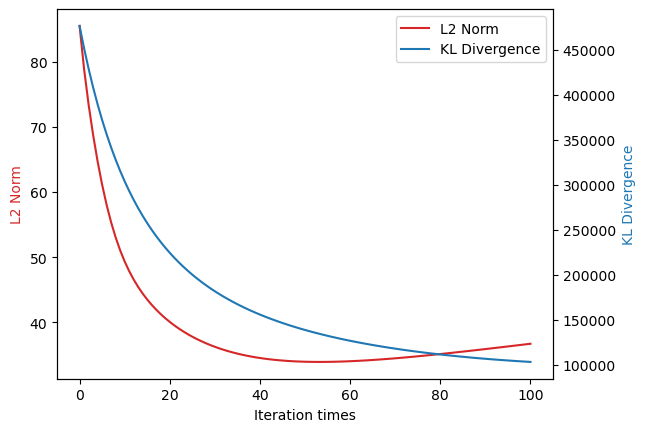

In [12]:
L2Norm = []


x00 = ig.allocate(value = 1)
ones1 = ag.allocate(value = 1)
m1 = A.adjoint(ones1)


for i in range(101):
    d1 = A.direct(x00)
    n1 = noisy_sino/d1
    p1 = A.adjoint(n1)
    x11 = p1*x00
    xnew1 = x11/m1
    x00 = xnew1
    
        
    L2squared = L2NormSquared(b = phantom)
    L2 = L2squared(xnew1)**(1/2)
    L2Norm.append(L2)
    
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("Iteration times")
ax1.set_ylabel("L2 Norm", color = color)
lns1 = ax1.plot(range(101), L2Norm, color = color, label = "L2 Norm")


KL = []


x000 = ig.allocate(value = 1)
ones11 = ag.allocate(value = 1)
m11 = A.adjoint(ones11)


for i in range(101):
    d11 = A.direct(x00)
    n11 = noisy_sino/d11
    p11 = A.adjoint(n11)
    x11 = p11*x000
    xnew11 = x11/m11
    x000 = xnew11

    b = noisy_sino.as_array()
    a = (A.direct(xnew11)).as_array()
    

    div = sp.kl_div(b, a)
    div_sum = np.sum(div)
    KL.append(div_sum)
    
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel("KL Divergence", color = color)
lns2 = ax2.plot(range(101), KL, color = color, label = "KL Divergence")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc = 'upper right')

plt.savefig('l2k2noise.png')
plt.show